Deep HW - Q2<br/>
Soroosh Noorzad - 99205372

## Table Of Contents:
* [PART A - GENERATE PICS](#PA)
* [PART B - Imbalanced Dataset](#PB)
* [PART C - Fix B](#PC)

# PART A - GENERATE PICS:<a class="anchor" id="PA"></a>

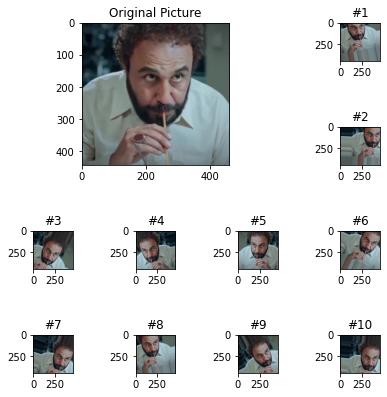

In [2]:
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from pathlib import Path
# Creating directories if not exist.
Path("figs").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# load the image
img = load_img('test.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=0.3, height_shift_range=0.3,)
# prepare iterator
it = datagen.flow(samples, batch_size=1)

# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(4,4)
position = [(0,3),(1,3),(2,0),(2,1),(2,2),(2,3),(3,0),(3,1),(3,2),(3,3)]

# large subplot
plt.subplot2grid((4,4), (0,0), colspan=3, rowspan=2)
plt.title('Original Picture')
plt.imshow(img)


for i in range(10):
  batch = it.next()
  image = batch[0].astype('uint8')

  plt.subplot2grid((4,4), position[i])
  plt.title("#"+str(i+1))
  plt.imshow(image)


# fit subplots and save fig
fig.tight_layout()
fig.set_size_inches(w=6,h=6)
fig.savefig('figs/generated_images.png')

# PART B - Imbalanced Dataset:<a class="anchor" id="PB"></a>

Importing libraries.
TensorFlow version: 2.7.0
Libraries imported.

Reading data started.
170508288/170498071 [==============================] - 6s 0us/step
Reading data finished.

Remove some random samples from Plane and Bird.
Samples have been removed.


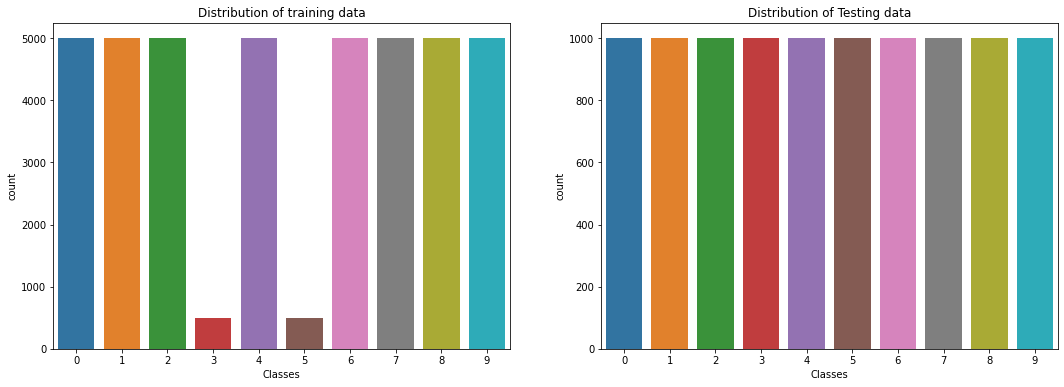

Creating the model.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                    

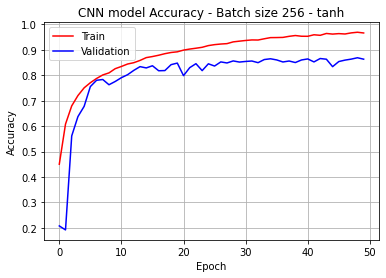


Plot the Loss Curves


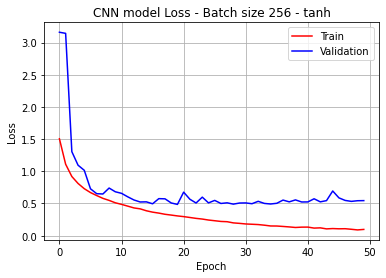


Test the model:
313/313 [==============================] - 3s 9ms/step - loss: 1.0726 - accuracy: 0.7583
Test Loss: 1.0726252794265747 , Test Accuracy: 0.7583000063896179

Plot Confusion Matrix:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.84      0.95      0.89      1000
           2       0.61      0.76      0.68      1000
           3       0.63      0.27      0.38      1000
           4       0.68      0.83      0.75      1000
           5       0.77      0.38      0.51      1000
           6       0.73      0.91      0.81      1000
           7       0.76      0.87      0.81      1000
           8       0.88      0.90      0.89      1000
           9       0.87      0.87      0.87      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.74     10000
weighted avg       0.76      0.76      0.74     10000



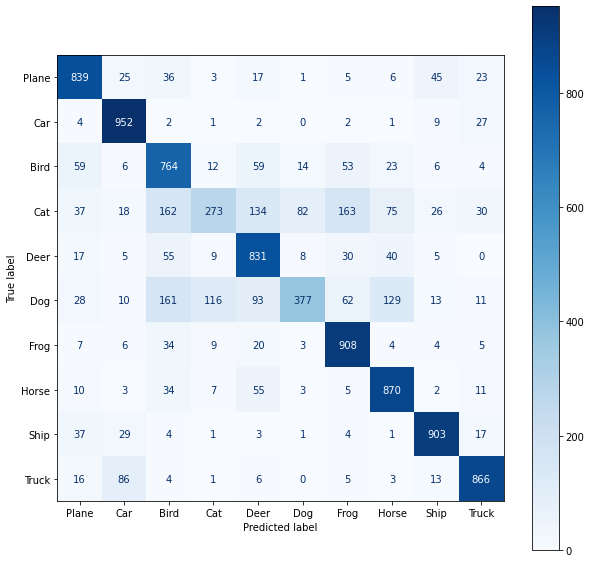

Job is done. learning time: 443 seconds


In [3]:
# Import TF and other requirements
print("Importing libraries.")
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import datasets, layers, models, Sequential, optimizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Import General libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import os

# Read Data
from six.moves import cPickle as pickle
import ssl
from keras.datasets import cifar10
import seaborn as sns

# Draw Flow chart
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

print("Libraries imported.\n")

from pathlib import Path
# Creating directories if not exist.
Path("figs").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# Defines:
question_part = "Q2PB"
model_type = "CNN"

# Hyper-Parameters
num_training=49000
num_validation=1000
num_test=10000
# database path
data_path = 'cifar10'
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
class_count = len(classes)
# Optimizer type: sgd, adam
opt_type = 'sgd'
# Batch Size:
bs = 256
# Activation Function:
act_func = 'tanh'
# Epoch count:
ep_count = 50
# Loss metric:
loss_metric = 'categorical_crossentropy'

def model_plotter(model_history, metric, model_name, b_s, a_f):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s) + " - " + a_f)
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig("figs/" + question_part + "_" + model_name + "_" + metric.lower() + "_" + str(b_s) + "_" + a_f + ".png")
    plt.show()

def read_data(path='cifar10'):
    xs = []
    ys = []
    for b in range(1,6):
        # load single batch of cifar
        filename = os.path.join(path, 'data_batch_%d' % (b, ))
        with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data'].reshape(10000, 3072)
            Y = np.array(datadict['labels'])
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    with open(os.path.join(path, 'test_batch'), 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        Xte = datadict['data'].reshape(10000, 3072)
        Yte = np.array(datadict['labels'])
    
    # Subsample the data
    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)
    x_val = Xtr[r_val].astype('float32')/255.0
    y_val = Ytr[r_val]

    # We can split data here, but we don't want.
    # x_train = Xtr[r_tr].astype('float32')/255.0
    # y_train = Ytr[r_tr]
    x_train = Xtr.astype('float32')/255.0
    y_train = Ytr

    x_test = Xte[r_te].astype('float32')/255.0
    y_test = Yte[r_te]
    return x_train, y_train, x_val, y_val, x_test, y_test

print("Reading data started.")
read_data_online = True
if read_data_online:
    # Read data, using Keras (Needs download):
    ssl._create_default_https_context = ssl._create_unverified_context
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)

    x_val = x_train[r_val].astype('float32')/255.0
    y_val = y_train[r_val]
    # x_train = x_train[r_tr].astype('float32')/255.0
    x_train = x_train.astype('float32')/255.0
    # y_train = y_train[r_tr]
    x_test = x_test[r_te].astype('float32')/255.0
    y_test = y_test[r_te]
    xtr_img = x_train
    xte_img = x_test
else:
    # Read data, using the defined function (locally - Downloaded file):
    x_train, y_train, x_val, y_val, x_test, y_test = read_data(data_path)
    xtr_img = x_train.reshape(len(x_train), 3, 32, 32).transpose([0, 2, 3, 1])
    xte_img = x_test.reshape(len(x_test), 3, 32, 32).transpose([0, 2, 3, 1])

# Making classes one hot for the sake of model training:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, class_count)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, class_count)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, class_count)

print("Reading data finished.\n")

print("Remove some random samples from Plane and Bird.")
index = []
index.append(np.where(y_train == 3))
index.append(np.where(y_train == 5))
# print(len(index[0][0]), len(index[1][0]))

remove_index = []
remove_index.append(random.sample(index[0][0].tolist(), int(len(index[0][0])*(0.9))))
remove_index.append(random.sample(index[1][0].tolist(), int(len(index[1][0])*(0.9))))
remove_index.append(remove_index[0] + remove_index[1])
# print(len(remove_index[0]), len(remove_index[1]), len(remove_index[2]))

y_train = np.delete(y_train, remove_index[2], axis=0)
x_train = np.delete(x_train, remove_index[2], axis=0)
xtr_img = np.delete(xtr_img, remove_index[2], axis=0)
y_train_one_hot = np.delete(y_train_one_hot, remove_index[2], axis=0)
print("Samples have been removed.")

figure, axis = plt.subplots( 1, 2 , figsize = (18,6))
sns.countplot(x=y_train.ravel(), ax = axis[0])
axis[0].set_title('Distribution of training data')
axis[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(x=y_test.ravel(), ax=axis[1])
axis[1].set_title('Distribution of Testing data')
axis[1].set_xlabel('Classes')
plt.savefig("figs/imbalanced_dist.png")
plt.show()

print("Creating the model.")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = act_func, name = 'FC1_h_128_' + act_func))
model.add(tf.keras.layers.Dense(128, activation = act_func, name = 'FC2_h_128_' + act_func))
model.add(tf.keras.layers.Dense(10, activation = 'softmax', name = 'FC3_o_10_Softmax'))
if opt_type=='adam':
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0009)
else:
    # opt_type=='sgd'
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name=opt_type.upper())
model.compile(optimizer = opt, loss = loss_metric, metrics = ['accuracy'])
model.summary()

print("Model created.\n")

print("Learn the model, Batch size =", bs)
t = time.time()
model_learning = model.fit(x_train, y_train_one_hot, epochs = ep_count, batch_size=bs, validation_split=0.2, shuffle=True)
t = time.time()-t

print("\nPlot the Accuracy Curves")
model_plotter(model_learning, 'accuracy', model_type, bs, act_func)

print("\nPlot the Loss Curves")
model_plotter(model_learning, 'loss', model_type, bs, act_func)

model.save("models/cifar10_" + question_part + "_" + model_type + "_bs" + str(bs) + "_" + act_func + ".h5")

# Model Testing:
print("\nTest the model:")
model_test_result = model.evaluate(x_test, y_test_one_hot)
print("Test Loss:", model_test_result[0], ", Test Accuracy:", model_test_result[1])

print("\nPlot Confusion Matrix:")
# Confusion Matrix:
y_pred_softmax = model.predict(x_test)
y_pred = [np.argmax(y) for y in y_pred_softmax]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("figs/" + question_part + "_" + model_type + "_confusion_" + str(bs) + "_" + act_func +  ".png")
plt.show()

print("Job is done. learning time:", int(t), "seconds")

# PART C - Fix B:<a class="anchor" id="PC"></a>

Importing libraries.
TensorFlow version: 2.7.0
Libraries imported.

Reading data started.
Reading data finished.

Remove some random samples from Plane and Bird.
Samples have been removed.

Augmentation is running...
New pictures added.



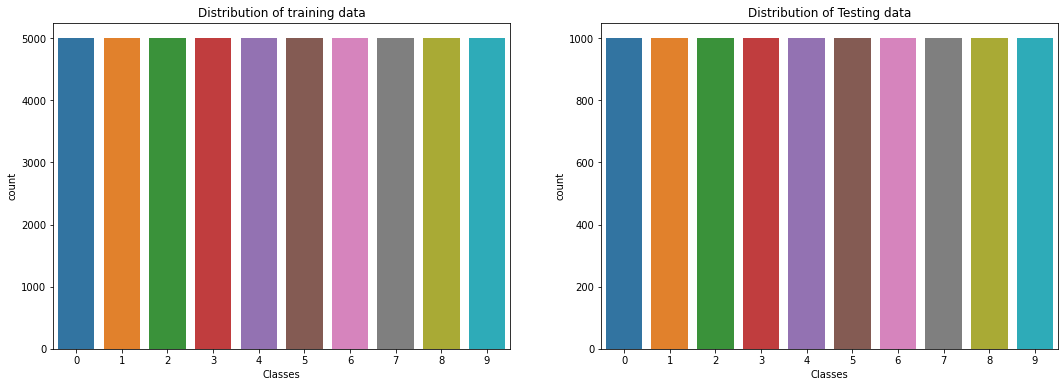

Creating the model.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                  

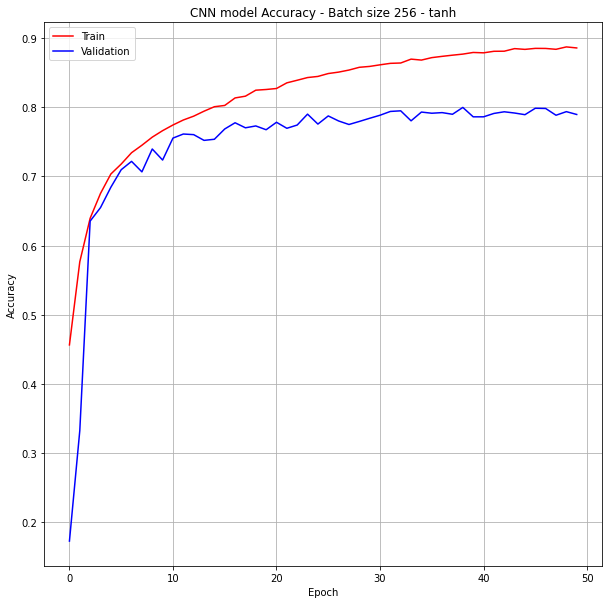


Plot the Loss Curves


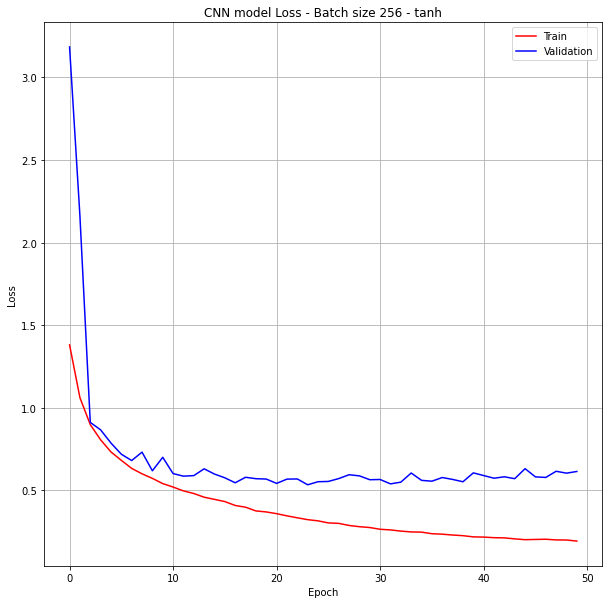


Test the model:
313/313 [==============================] - 3s 8ms/step - loss: 1.1591 - accuracy: 0.7513
Test Loss: 1.1591399908065796 , Test Accuracy: 0.7512999773025513

Plot Confusion Matrix:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1000
           1       0.92      0.87      0.90      1000
           2       0.57      0.77      0.66      1000
           3       0.70      0.24      0.36      1000
           4       0.71      0.81      0.75      1000
           5       0.79      0.35      0.49      1000
           6       0.69      0.91      0.78      1000
           7       0.76      0.87      0.81      1000
           8       0.84      0.91      0.88      1000
           9       0.79      0.93      0.86      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.73     10000
weighted avg       0.76      0.75      0.73     10000



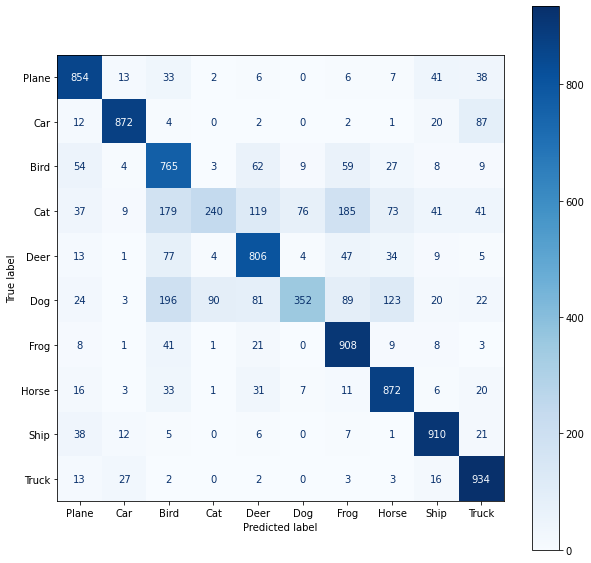

Job is done. learning time: 503 seconds


In [4]:
# Import TF and other requirements
print("Importing libraries.")
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import datasets, layers, models, Sequential, optimizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Import General libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import os

# Read Data
from six.moves import cPickle as pickle
import ssl
from keras.datasets import cifar10
import seaborn as sns

# Draw Flow chart
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

# Image generate
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator

print("Libraries imported.\n")

from pathlib import Path
# Creating directories if not exist.
Path("figs").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# Defines:
question_part = "Q2PC"
model_type = "CNN"

# Hyper-Parameters
num_training=49000
num_validation=1000
num_test=10000
# database path
data_path = 'cifar10'
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
class_count = len(classes)
# Optimizer type: sgd, adam
opt_type = 'sgd'
# Batch Size:
bs = 256
# Activation Function:
act_func = 'tanh'
# Epoch count:
ep_count = 50
# Loss metric:
loss_metric = 'categorical_crossentropy'

def model_plotter(model_history, metric, model_name, b_s, a_f):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s) + " - " + a_f)
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig("figs/" + question_part + "_" + model_name + "_" + metric.lower() + "_" + str(b_s) + "_" + a_f + ".png")
    plt.show()

def read_data(path='cifar10'):
    xs = []
    ys = []
    for b in range(1,6):
        # load single batch of cifar
        filename = os.path.join(path, 'data_batch_%d' % (b, ))
        with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data'].reshape(10000, 3072)
            Y = np.array(datadict['labels'])
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    with open(os.path.join(path, 'test_batch'), 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        Xte = datadict['data'].reshape(10000, 3072)
        Yte = np.array(datadict['labels'])
    
    # Subsample the data
    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)
    x_val = Xtr[r_val].astype('float32')/255.0
    y_val = Ytr[r_val]

    # We can split data here, but we don't want.
    # x_train = Xtr[r_tr].astype('float32')/255.0
    # y_train = Ytr[r_tr]
    x_train = Xtr.astype('float32')/255.0
    y_train = Ytr

    x_test = Xte[r_te].astype('float32')/255.0
    y_test = Yte[r_te]
    return x_train, y_train, x_val, y_val, x_test, y_test

print("Reading data started.")
read_data_online = True
if read_data_online:
    # Read data, using Keras (Needs download):
    ssl._create_default_https_context = ssl._create_unverified_context
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    r_val = range(num_training, num_training + num_validation)
    r_tr = range(num_training)
    r_te = range(num_test)

    x_val = x_train[r_val].astype('float32')/255.0
    y_val = y_train[r_val]
    # x_train = x_train[r_tr].astype('float32')/255.0
    x_train = x_train.astype('float32')/255.0
    # y_train = y_train[r_tr]
    x_test = x_test[r_te].astype('float32')/255.0
    y_test = y_test[r_te]
    xtr_img = x_train
    xte_img = x_test
else:
    # Read data, using the defined function (locally - Downloaded file):
    x_train, y_train, x_val, y_val, x_test, y_test = read_data(data_path)
    xtr_img = x_train.reshape(len(x_train), 3, 32, 32).transpose([0, 2, 3, 1])
    xte_img = x_test.reshape(len(x_test), 3, 32, 32).transpose([0, 2, 3, 1])

# Making classes one hot for the sake of model training:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, class_count)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, class_count)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, class_count)

print("Reading data finished.\n")

print("Remove some random samples from Plane and Bird.")
index = []
index.append(np.where(y_train == 3))
index.append(np.where(y_train == 5))
# print(len(index[0][0]), len(index[1][0]))

remove_index = []
remove_index.append(random.sample(index[0][0].tolist(), int(len(index[0][0])*(0.9))))
remove_index.append(random.sample(index[1][0].tolist(), int(len(index[1][0])*(0.9))))
remove_index.append(remove_index[0] + remove_index[1])
# print(len(remove_index[0]), len(remove_index[1]), len(remove_index[2]))

y_train = np.delete(y_train, remove_index[2], axis=0)
x_train = np.delete(x_train, remove_index[2], axis=0)
xtr_img = np.delete(xtr_img, remove_index[2], axis=0)
y_train_one_hot = np.delete(y_train_one_hot, remove_index[2], axis=0)
print("Samples have been removed.")

print("\nAugmentation is running...")
remained_index = []
remained_index.append(np.where(y_train == 3)[0].tolist())
remained_index.append(np.where(y_train == 5)[0].tolist())
remained_index.append(remained_index[0] + remained_index[1])

# expand dimension to one sample
samples = []
samples.append(expand_dims(x_train[remained_index[0]], 0))
samples.append(expand_dims(x_train[remained_index[1]], 0))

# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=0.3, height_shift_range=0.3,)
# prepare iterator
iterator = []
iterator.append(datagen.flow(samples[0][0], batch_size=1))
iterator.append(datagen.flow(samples[1][0], batch_size=1))

x_gen = [[],[]]
for i in range(int(len(index[0][0])*(0.9))):
  batch = iterator[0].next()
  x_gen[0].append(batch[0].astype('uint8'))

for i in range(int(len(index[1][0])*(0.9))):
  batch = iterator[1].next()
  x_gen[1].append(batch[0].astype('uint8'))

gen_y = np.array([[3]]*len(x_gen[0])+[[5]]*len(x_gen[1]))
gen_y_one_hot = tf.keras.utils.to_categorical(gen_y, class_count)

x_train = np.append(x_train, x_gen[0], axis=0)
x_train = np.append(x_train, x_gen[1], axis=0)
y_train = np.append(y_train, gen_y, axis=0)
y_train_one_hot = np.append(y_train_one_hot, gen_y_one_hot, axis=0)
print("New pictures added.\n")

figure, axis = plt.subplots( 1, 2 , figsize = (18,6))
sns.countplot(x=y_train.ravel(), ax = axis[0])
axis[0].set_title('Distribution of training data')
axis[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(x=y_test.ravel(), ax=axis[1])
axis[1].set_title('Distribution of Testing data')
axis[1].set_xlabel('Classes')
plt.savefig("figs/imbalanced_dist.png")
plt.show()

print("Creating the model.")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = act_func, name = 'FC1_h_128_' + act_func))
model.add(tf.keras.layers.Dense(128, activation = act_func, name = 'FC2_h_128_' + act_func))
model.add(tf.keras.layers.Dense(10, activation = 'softmax', name = 'FC3_o_10_Softmax'))
if opt_type=='adam':
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0009)
else:
    # opt_type=='sgd'
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name=opt_type.upper())
model.compile(optimizer = opt, loss = loss_metric, metrics = ['accuracy'])
model.summary()

print("Model created.\n")

print("Learn the model, Batch size =", bs)

# Shuffle data
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)
idx = tf.random.shuffle(indices)
x_train = tf.gather(x_train, idx)
y_train = tf.gather(y_train, idx)
y_train_one_hot = tf.gather(y_train_one_hot, idx)

t = time.time()
model_learning = model.fit(x_train, y_train_one_hot, epochs = ep_count, batch_size=bs, validation_split=0.2, shuffle=True)
t = time.time()-t

print("\nPlot the Accuracy Curves")
model_plotter(model_learning, 'accuracy', model_type, bs, act_func)

print("\nPlot the Loss Curves")
model_plotter(model_learning, 'loss', model_type, bs, act_func)

model.save("models/cifar10_" + question_part + "_" + model_type + "_bs" + str(bs) + "_" + act_func + ".h5")

# Model Testing:
print("\nTest the model:")
model_test_result = model.evaluate(x_test, y_test_one_hot)
print("Test Loss:", model_test_result[0], ", Test Accuracy:", model_test_result[1])

print("\nPlot Confusion Matrix:")
# Confusion Matrix:
y_pred_softmax = model.predict(x_test)
y_pred = [np.argmax(y) for y in y_pred_softmax]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("figs/" + question_part + "_" + model_type + "_confusion_" + str(bs) + "_" + act_func +  ".png")
plt.show()

print("Job is done. learning time:", int(t), "seconds")